# INF250 - Assignment 2

In [36]:
import skimage
from skimage import io, color, filters, feature, measure, morphology
import numpy as np
import matplotlib.pyplot as plt

/var/folders/gf/ltk57v_95wdgd_bbsrsl7_9m0000gn/T/ipykernel_11627/1691170106.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(image);


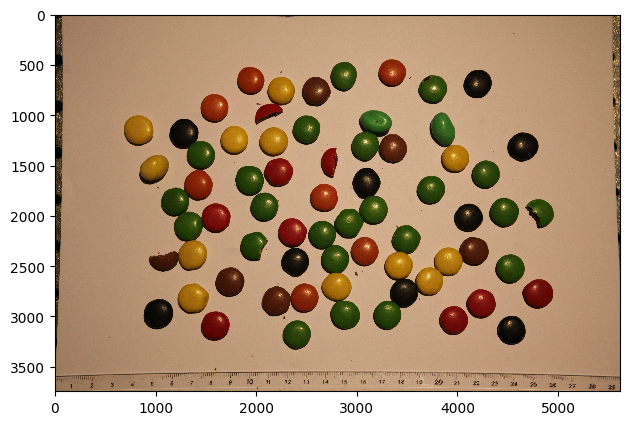

In [37]:
image = skimage.io.imread("IMG_2754_nonstop_alltogether.JPG")
skimage.io.imshow(image);

In [38]:
import skimage.color

# Fix weird 2-channel or RGBA images
if image.ndim == 2:
    image = skimage.color.gray2rgb(image)
elif image.shape[2] == 4:  # RGBA -> RGB
    image = skimage.color.rgba2rgb(image)
elif image.shape[2] == 2:  # Gray + Alpha -> just use first channel
    image = skimage.color.gray2rgb(image[..., 0])


/var/folders/gf/ltk57v_95wdgd_bbsrsl7_9m0000gn/T/ipykernel_11627/2563508896.py:12: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(blurred_image);


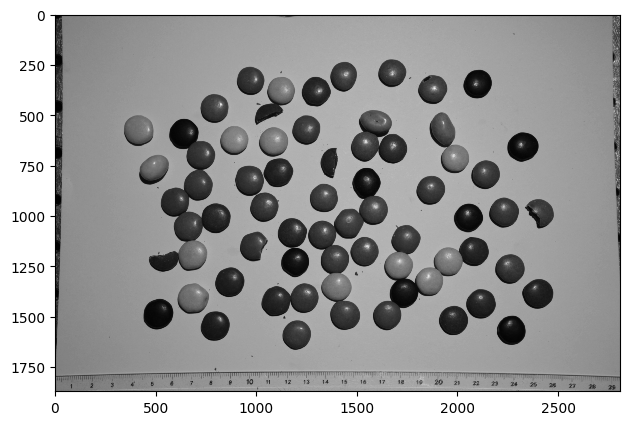

In [39]:
SCALE = 0.5

# Convert the image to grayscale
gray_image = skimage.color.rgb2gray(image)

small_image = skimage.transform.rescale(gray_image, SCALE, anti_aliasing=True)

# Reduce the noise in the image with gaussian filter
blurred_image = skimage.filters.gaussian(small_image, sigma=1)

# Display the processed images
skimage.io.imshow(blurred_image);

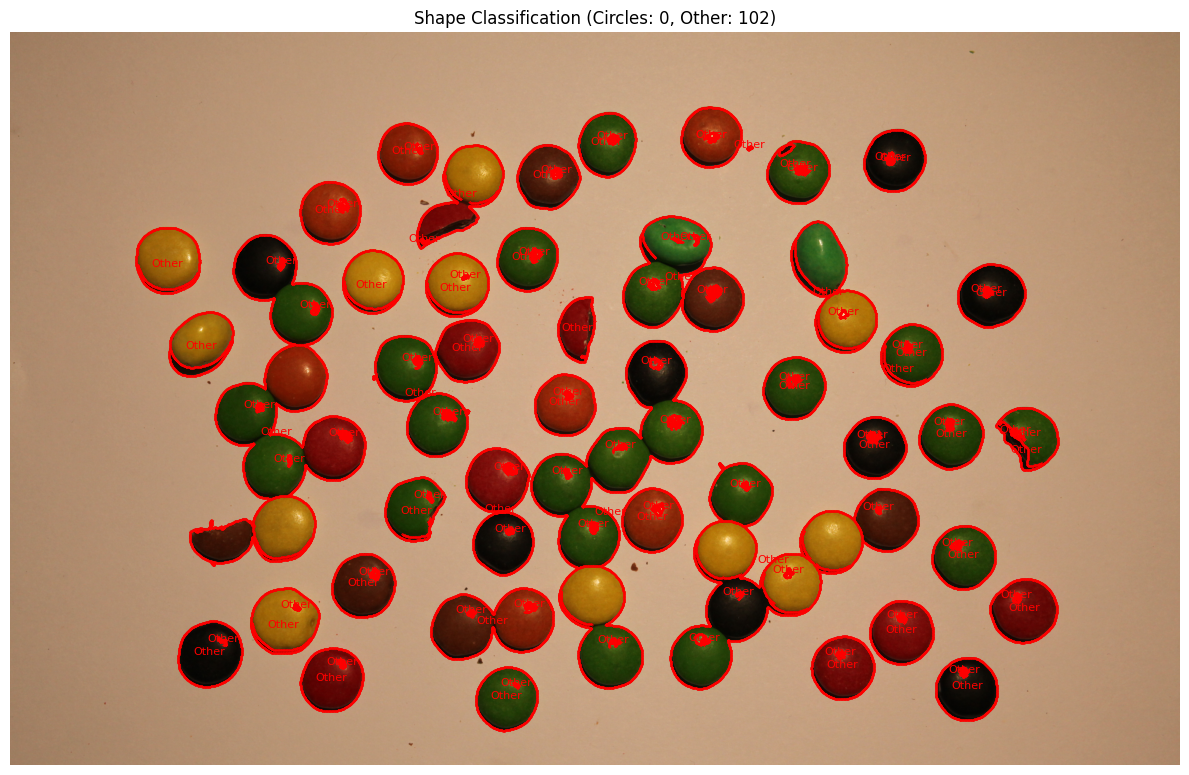


Detected 0 circles and 102 other shapes


In [22]:
import numpy as np
import skimage
from skimage import filters, morphology, measure, feature
from scipy import ndimage
import matplotlib.pyplot as plt

image = skimage.io.imread('IMG_2754_nonstop_alltogether.jpg')

crop_top = 100
crop_bottom = -250
crop_left = 100
crop_right = -100

image_cropped = image[crop_top:crop_bottom, crop_left:crop_right]

gray = skimage.color.rgb2gray(image_cropped)
blurred = filters.gaussian(gray, sigma=2)

edges = feature.canny(blurred, sigma=1)

filled = morphology.remove_small_holes(edges, area_threshold=100)
filled = morphology.binary_closing(filled, morphology.disk(3))

labels = measure.label(filled)
regions = measure.regionprops(labels)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image_cropped)

circles = []
others = []

for region in regions:
    area = region.area
    perimeter = region.perimeter
    
    if area < 200:
        continue
    
    if perimeter == 0:
        continue
    
    circularity = 4 * np.pi * area / (perimeter ** 2)
    
    major_axis = region.axis_major_length
    minor_axis = region.axis_minor_length
    if major_axis > 0:
        axis_ratio = minor_axis / major_axis
    else:
        axis_ratio = 0
    
    y, x = region.centroid
    
    if circularity > 0.85 and axis_ratio > 0.9:
        color = 'lime'
        label = "Circle"
        circles.append(region)
    else:
        color = 'red'
        label = "Other"
        others.append(region)
    
    for coords in region.coords:
        ax.plot(coords[1], coords[0], '.', color=color, markersize=0.5)
    
    ax.text(x, y, label, color=color, fontsize=8, ha='center')

ax.set_title(f"Shape Classification (Circles: {len(circles)}, Other: {len(others)})")
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nDetected {len(circles)} circles and {len(others)} other shapes")